# Autoencoder in Pytorch

Resources:
- https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1
- https://github.com/pytorch/examples/blob/master/vae/main.py

## Setup

In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import torchvision

from matplotlib import pyplot as plt

In [2]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def show_mnist_output(original, reconstruction):
    fig, axs = plt.subplots(nrows=1, ncols=2)

    # original
    axs[0].imshow(
        original.data.view(28, 28),
        aspect="equal"
    )
    axs[0].set_title("Original")
    axs[0].axis('off')

    # reconstruction
    axs[1].imshow(
        reconstruction.data.view(28, 28),
        aspect="equal"
    )
    axs[1].set_title("Reconstruction")
    axs[1].axis('off')

    plt.suptitle("AE MNIST reconstruction")
    plt.tight_layout()
    plt.show()

## Dataset

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="../torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

## Training

### Auto Encoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        
        return reconstructed

In [6]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=784).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [7]:
epochs = 10
model.train()

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.031660
epoch : 2/10, loss = 0.017325
epoch : 3/10, loss = 0.015262
epoch : 4/10, loss = 0.014250
epoch : 5/10, loss = 0.013629
epoch : 6/10, loss = 0.013197
epoch : 7/10, loss = 0.012850
epoch : 8/10, loss = 0.012556
epoch : 9/10, loss = 0.012304
epoch : 10/10, loss = 0.012082


In [9]:
model.eval()

for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, 784).to(device)
    
    outputs = model(batch_features)
    
    break

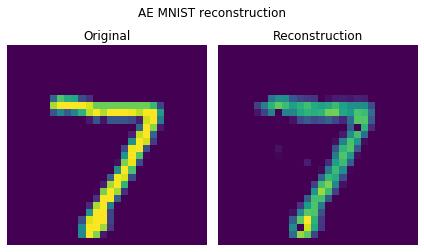

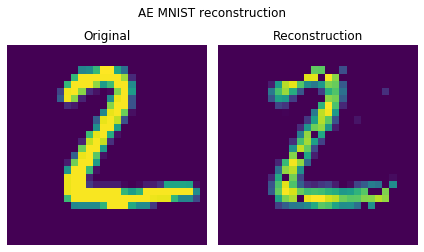

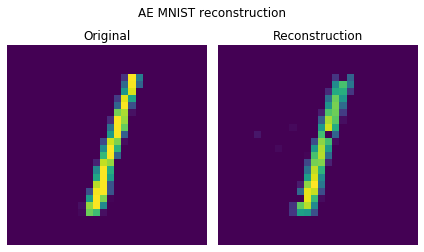

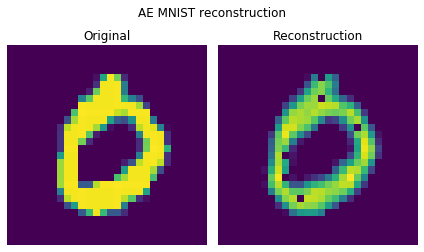

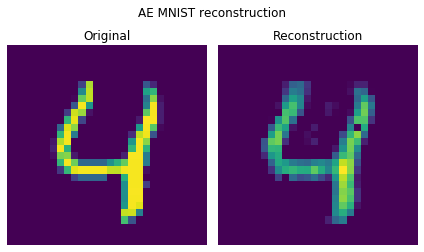

In [12]:
for i in range(5):
    show_mnist_output(batch_features[i], outputs[i])

### Variational Auto Encoder

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [14]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [15]:
epochs = 10
model.train()

for epoch in range(epochs):
    train_loss = 0
    
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        recon_batch, mu, logvar = model(batch_features)
        loss = loss_function(recon_batch, batch_features, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    # compute the epoch training loss
    train_loss = train_loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, train_loss))

epoch : 1/10, loss = 21160.015340
epoch : 2/10, loss = 15586.916805
epoch : 3/10, loss = 14663.239529
epoch : 4/10, loss = 14283.879952
epoch : 5/10, loss = 14056.820156
epoch : 6/10, loss = 13909.261327
epoch : 7/10, loss = 13796.555283
epoch : 8/10, loss = 13714.705243
epoch : 9/10, loss = 13648.565515
epoch : 10/10, loss = 13594.669176


In [16]:
model.eval()

for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, 784).to(device)
    
    recon_batch, _, _ = model(batch_features)
    
    break

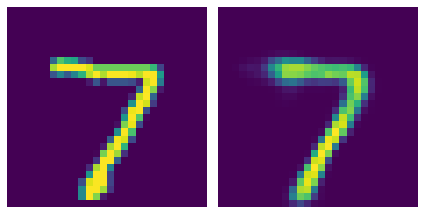

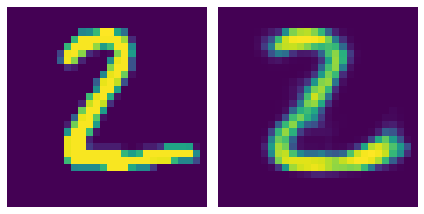

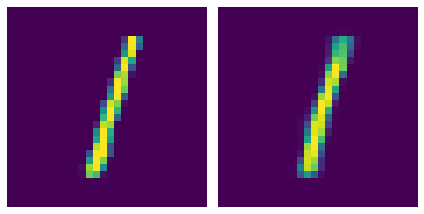

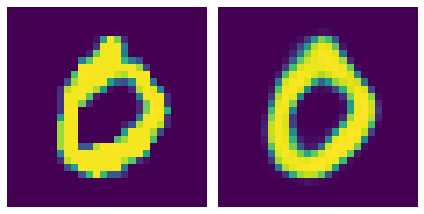

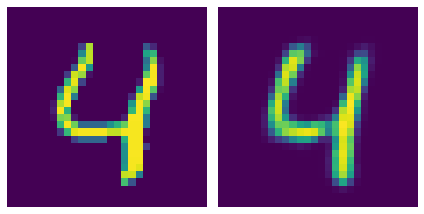

In [20]:
for i in range(5):
    show_mnist_output(batch_features[i], recon_batch[i])